In [1]:
import os
import glob

import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import folium
from IPython.display import Image
from geopy.geocoders import Nominatim

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Specify the folder path where the files are located
folder_path = '../Data'

# Create an empty list to store file names
file_names = []

# Use a loop to iterate over all files in the folder
for file_name in glob.glob(os.path.join(folder_path, '*')):
    # Append the full file path to the list
    file_names.append(folder_path + '/' + os.path.basename(file_name))

# Return the list of file names
file_names

['../Data/Building.csv',
 '../Data/Floor.csv',
 '../Data/Room.csv',
 '../Data/Entitlement Group.csv',
 '../Data/RoomBookingLog.csv',
 '../Data/Neighborhood.csv',
 '../Data/Rule.csv',
 '../Data/Desk_Booking_Log.csv',
 '../Data/Desk.csv']

In [3]:
# Read the data into seperate pandas dataframes
Building_df = pd.read_csv(file_names[0])
Floor_df = pd.read_csv(file_names[1])
Room_df = pd.read_csv(file_names[2])
Desk_df = pd.read_csv(file_names[8])

Rule_df = pd.read_csv(file_names[6])
Neighborhood_df = pd.read_csv(file_names[5])
EntitlementGroup_df = pd.read_csv(file_names[3])

RoomBookingLog_df = pd.read_csv(file_names[4])
DeskBookingLog_df = pd.read_csv(file_names[7])

In [4]:
Building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            73 non-null     object 
 1   MEETINGID     73 non-null     object 
 2   CITY          37 non-null     object 
 3   STATE         31 non-null     object 
 4   ZIPCODE       27 non-null     object 
 5   COORDINATE    0 non-null      float64
 6   COUNTRY       42 non-null     object 
 7   LASTMODIFIED  73 non-null     object 
 8   NAME          73 non-null     object 
 9   DATECREATED   73 non-null     object 
 10  ADDRESS       45 non-null     object 
dtypes: float64(1), object(10)
memory usage: 6.4+ KB


- Coordinate column seems to be empty.

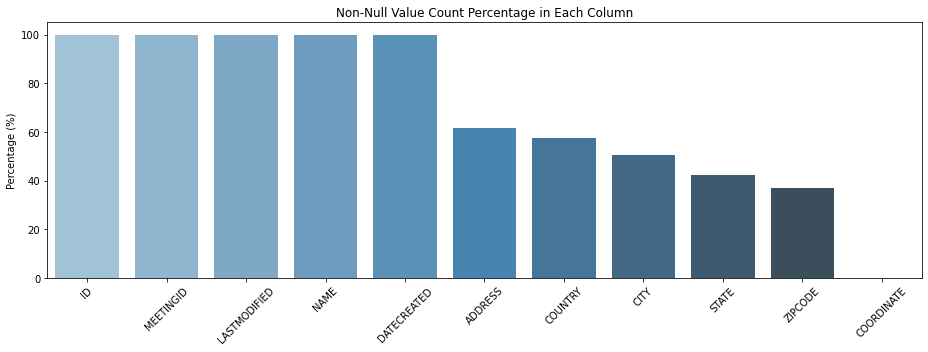

In [5]:
size = Building_df.shape[0]

# Calculate the percentage of null values in each column
null_percentage = (100*(1-(Building_df.isnull().sum()/size))).round(2).sort_values(ascending=False)

# Create a bar plot using Seaborn
plt.figure(figsize=(13, 5))
sns.barplot(x=null_percentage.index, y=null_percentage.values, palette='Blues_d')
plt.title('Non-Null Value Count Percentage in Each Column')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [6]:
RoomBookingLog_df['IS_CANCELLED'].value_counts()/RoomBookingLog_df.shape[0]

True     0.824602
False    0.175398
Name: IS_CANCELLED, dtype: float64

### TODO: Does True in IS_CANCELLED column mean that the trip was cancelled?

In [7]:
RoomBookingLog_df.columns

Index(['ID', 'LAST_MODIFIED', 'BUILDING_ID', 'MEETING_NAME', 'BUILDING_NAME',
       'ACCEPTED_COUNT', 'ROOM_ID', 'INVITED_COUNT', 'FLOOR_ID', 'START_TM',
       'TYPE', 'FLOOR_NAME', 'DATE_CREATED', 'ROOM_NAME', 'IS_CANCELLED',
       'END_TM', 'MEETING_ID'],
      dtype='object')

In [8]:
# Create a copy of the RoomBookingLog_df DataFrame and assign it to 'data'
data = RoomBookingLog_df.copy()

# Drop unnecessary columns from 'data'
data.drop(columns=['MEETING_NAME', 'BUILDING_NAME', 'ACCEPTED_COUNT', 'INVITED_COUNT', 'LAST_MODIFIED', 'TYPE', 'FLOOR_NAME', 'DATE_CREATED', 'ROOM_NAME'], inplace=True)

# data = data.loc[data['IS_CANCELLED'] == False]

# Convert 'START_TM' and 'END_TM' columns to datetime format
data['START_TM'] = pd.to_datetime(data['START_TM'])
data['END_TM'] = pd.to_datetime(data['END_TM'])


### Feature Engineering:
- Calculating the 'duration' of the meetings (in minutes) and adding it as a new column
- Converting the 'duration' column into 'counts' ( *__1 count = 30 minutes__* )

In [9]:
# Define a function to calculate duration
def calculate_duration(row):
    # If END_TM is on the next day, set it to midnight
    if row['END_TM'].date() > row['START_TM'].date():
        row['END_TM'] = row['END_TM'].replace(hour=23, minute=59, second=59)
    # Calculate duration in 30-minute intervals
    duration_seconds = (row['END_TM'] - row['START_TM']).total_seconds()
    return int(np.ceil(duration_seconds / (30 * 60)))

# Apply the function to calculate duration
data['Duration'] = data.apply(calculate_duration, axis=1)
data.drop(columns=['IS_CANCELLED', 'END_TM'], inplace=True)

data.head()

,ID,BUILDING_ID,ROOM_ID,FLOOR_ID,START_TM,MEETING_ID,Duration
0,RB958,B033,R1869,F108,2023-08-21 01:30:00+00:00,M019,1
1,RB847,B060,R835,F087,2023-08-21 02:01:00+00:00,M044,2
2,RB848,B033,R1869,F108,2023-08-21 02:30:00+00:00,M019,3
3,RB689,B042,R1215,F210,2023-08-15 18:00:00+00:00,M032,1
4,RB39717,B029,R1985,F183,2023-09-12 20:30:00+00:00,M016,1


In [10]:
# Filter the 'data' DataFrame to include rows with 'Duration' less than or equal to 12 hours
# data_cleaned = data.loc[data['Duration'] <= 24]

# Filter the 'data_cleaned' DataFrame to include rows with 'START_TM' years in [2021, 2022, 2023]
data_cleaned = data[data['START_TM'].dt.year.isin([2021, 2022, 2023])]


- Preliminary analysis of the data

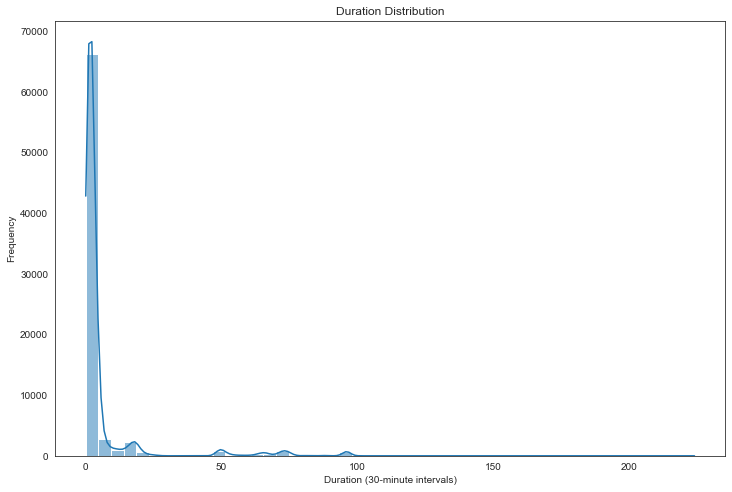

In [11]:
sns.set_style('white')
plt.figure(figsize=(12, 8))
sns.histplot(data_cleaned['Duration'], bins=48, kde=True)
plt.title('Duration Distribution')
plt.xlabel('Duration (30-minute intervals)')
plt.ylabel('Frequency')
plt.show()

- Most of the meetings are scheduled for 1 hour ( 2 counts )
- Most popular meeting duration is 1 - 2 hours, followed by 2 - 3 hours

In [12]:
# handling outliers
# keeing the data with duration less than 24 hours (1 day i.e, 48 30-minute intervals)
data_cleaned = data_cleaned.loc[(data_cleaned['Duration']<=48) & (data_cleaned['Duration']>0)]

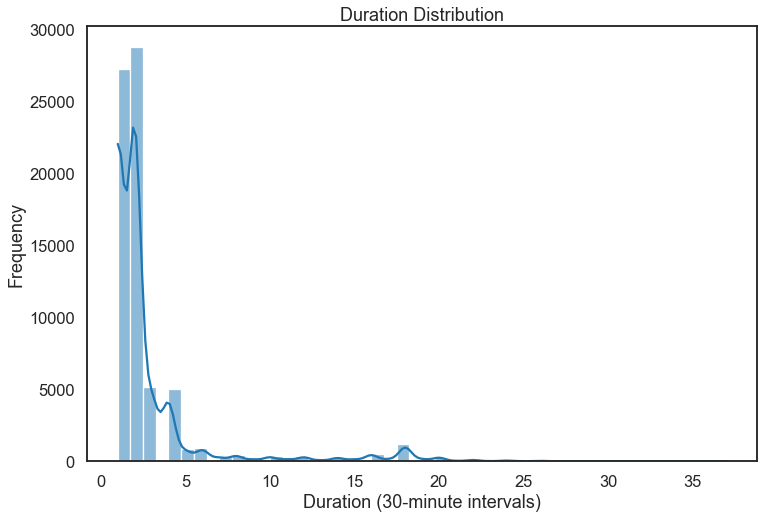

In [13]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(12, 8))
sns.histplot(data_cleaned['Duration'], bins=48, kde=True)
plt.title('Duration Distribution')
plt.xlabel('Duration (30-minute intervals)')
plt.ylabel('Frequency')
plt.show()

<AxesSubplot:>

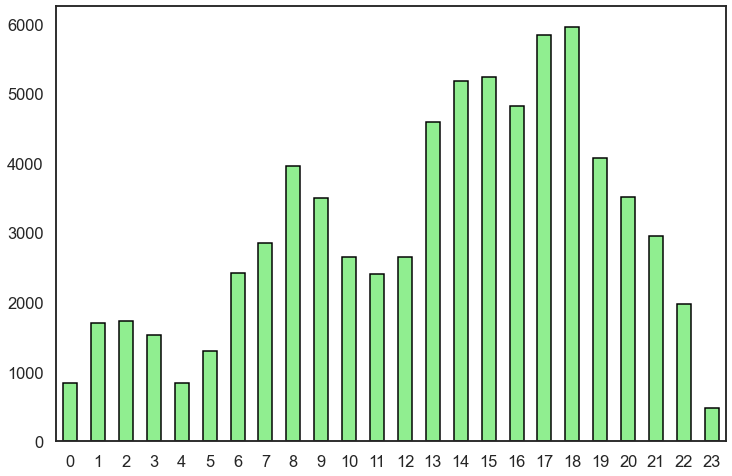

In [14]:
data_cleaned['START_TM'].dt.hour.value_counts().sort_index().plot(kind='bar', figsize=(12, 8), rot=0, color='lightgreen', edgecolor='black')

- Most of the meetings are scheduled during the day time ( 11 AM - 6 PM )

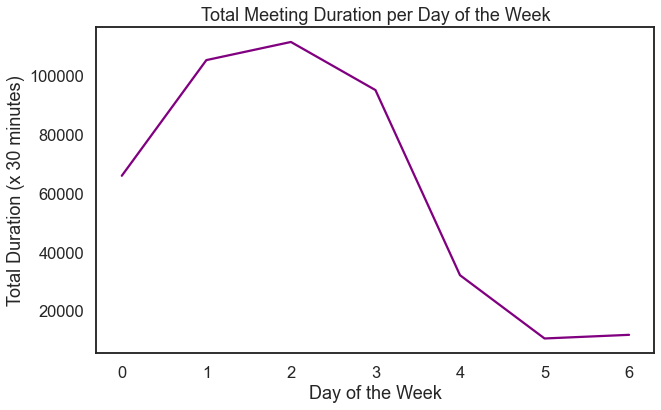

In [15]:
# Group by day of the week and calculate the total duration
duration_per_day_of_week = data.groupby(data['START_TM'].dt.dayofweek)['Duration'].sum()

# Create a figure with a single subplot
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

# Plot the duration per day of the week using Seaborn
sns.lineplot(x=duration_per_day_of_week.index, y=duration_per_day_of_week.values, ax=axes, color='purple')
axes.set_title('Total Meeting Duration per Day of the Week')
axes.set_xlabel('Day of the Week')
axes.set_ylabel('Total Duration (x 30 minutes)')

# Show the plot
plt.show()

- Most of the meetings are scheduled on weekdays ( Monday - Thursday )

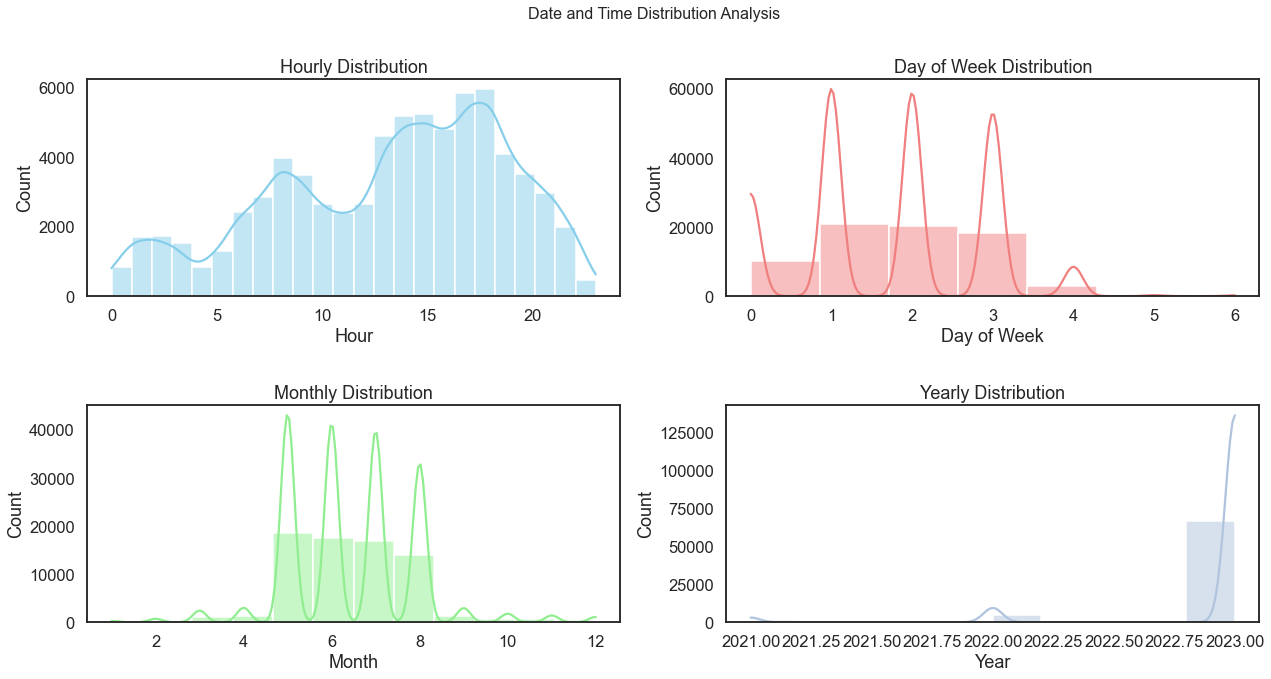

In [16]:
data = data_cleaned

# Create a figure and subplots with two rows and two columns
fig, axes = plt.subplots(2, 2, figsize=(21, 10))
fig.subplots_adjust(hspace=0.5)  # Adjust the vertical space between rows
sns.set_style('white')

# Plot 1 - Hourly distribution
sns.histplot(data=data, x=data['START_TM'].dt.hour, ax=axes[0, 0], color='skyblue', bins=24, kde=True)
axes[0, 0].set_title('Hourly Distribution')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Count')

# Plot 2 - Day of week distribution
sns.histplot(data=data, x=data['START_TM'].dt.dayofweek, ax=axes[0, 1], color='lightcoral', bins=7, kde=True)
axes[0, 1].set_title('Day of Week Distribution')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Count')

# Plot 3 - Monthly distribution
sns.histplot(data=data, x=data['START_TM'].dt.month, ax=axes[1, 0], color='lightgreen', bins=12, kde=True)
axes[1, 0].set_title('Monthly Distribution')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Count')

# Plot 4 - Yearly distribution
sns.histplot(data=data, x=data['START_TM'].dt.year, ax=axes[1, 1], color='lightsteelblue', bins=10, kde=True)
axes[1, 1].set_title('Yearly Distribution')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Count')

# Add a title for the entire figure
fig.suptitle('Date and Time Distribution Analysis', fontsize=16)

# Show the plots
plt.show()

#### Obersevations:
- A clear pattern can be observed when grouped by hour of the day, times such as 12pm to 8pm seem to be the most popular times for meetings.
- The most popular day of the week for meetings is Tuesday, followed by Wednesday and Thursday. While weekends are the least popular days for meetings.
- The most popular month for meetings is May, followed by June till August.

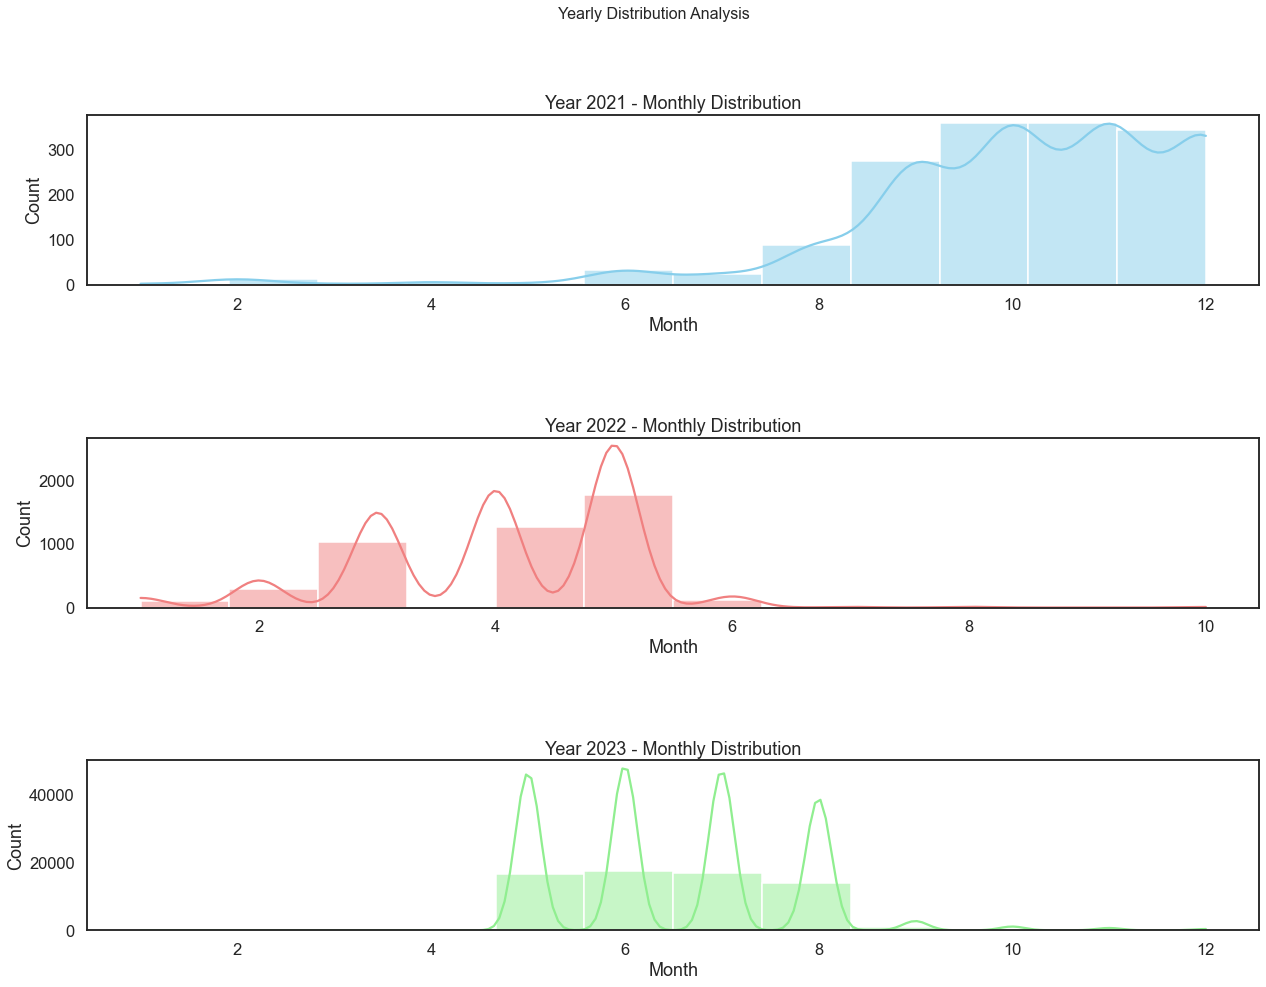

In [17]:
data_2021 = data.loc[data['START_TM'].dt.year == 2021]
data_2022 = data.loc[data['START_TM'].dt.year == 2022]
data_2023 = data.loc[data['START_TM'].dt.year == 2023]

fig, axes = plt.subplots(3, 1, figsize=(21, 15))
fig.subplots_adjust(hspace=0.9)  # Adjust the vertical space between rows

# Plot 1 - Yearly distribution - 2021
sns.histplot(data=data_2021, x=data_2021['START_TM'].dt.month, ax=axes[0], color='skyblue', bins=12, kde=True)
axes[0].set_title('Year 2021 - Monthly Distribution')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Count')

# Plot 2 - Yearly distribution - 2022
sns.histplot(data=data_2022, x=data_2022['START_TM'].dt.month, ax=axes[1], color='lightcoral', bins=12, kde=True)
axes[1].set_title('Year 2022 - Monthly Distribution')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Count')

# Plot 3 - Yearly distribution - 2023
sns.histplot(data=data_2023, x=data_2023['START_TM'].dt.month, ax=axes[2], color='lightgreen', bins=12, kde=True)
axes[2].set_title('Year 2023 - Monthly Distribution')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Count')

# Add a title for the entire figure
fig.suptitle('Yearly Distribution Analysis', fontsize=16)

# Show the plots
plt.show()

- Yealy data seems to be skewed i.e, suspecting class imablance towards year 2023 (being most popular).
- Possible causes can encompass a wide range of factors, spanning from the impact of COVID-19 to the inherent incompleteness of the data.

In [18]:
Building_df.shape

(73, 11)

In [19]:
value_counts = RoomBookingLog_df['BUILDING_ID'].value_counts()

# sorted_values unique values by counts in descending order
sorted_values = value_counts.index.tolist()

# Initialize variables for counting
size = RoomBookingLog_df.shape[0]

len(value_counts), size

(43, 77139)

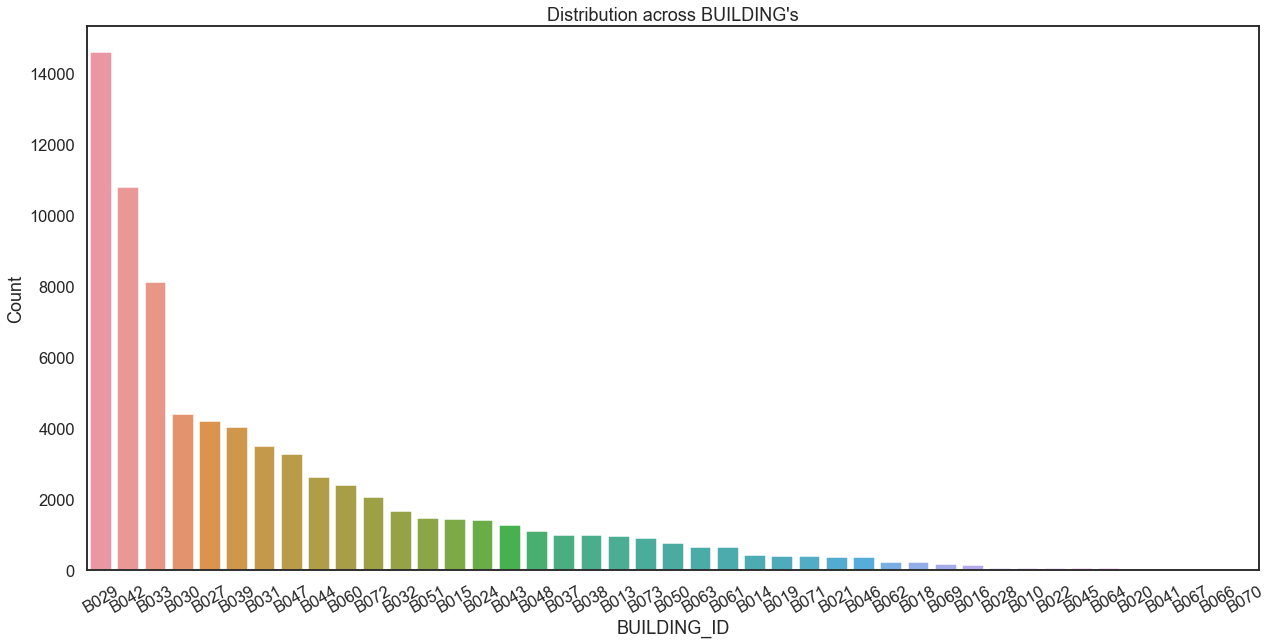

In [20]:
# Use Seaborn to create a countplot based on 'BUILDING_ID' column
plt.figure(figsize=(21, 10))
sns.countplot(data=RoomBookingLog_df, x='BUILDING_ID', order=RoomBookingLog_df['BUILDING_ID'].value_counts().index)
plt.xticks(rotation=30)
plt.xlabel('BUILDING_ID')
plt.ylabel('Count')
plt.title("Distribution across BUILDING's")
plt.show()

- Just 5 Buildings account for 50% of the total meetings.

In [21]:
cumulative_count = 0
selected_values = {}

# Iterate through the sorted values until cumulative count > 80%
for value in sorted_values:
    cumulative_count += value_counts[value]
    selected_values[value] = value_counts[value]
    if cumulative_count > 0.8 * size:
        break

print(len(selected_values), 'BUILDING_IDs selected')

sorted_values = sorted(selected_values.items(), key=lambda x: x[1], reverse=True)
for i in range(len(sorted_values)):
    sorted_values[i] = list(sorted_values[i])

sorted_values

13 BUILDING_IDs selected


[['B029', 14604],
 ['B042', 10800],
 ['B033', 8111],
 ['B030', 4407],
 ['B027', 4212],
 ['B039', 4039],
 ['B031', 3483],
 ['B047', 3268],
 ['B044', 2624],
 ['B060', 2386],
 ['B072', 2066],
 ['B032', 1656],
 ['B051', 1452]]

In [22]:
Floor_df.columns

Index(['ID', 'MEETING_ID', 'NAME', 'LAST_MODIFIED', 'SQUARE_FOOT',
       'DATE_CREATED', 'BUILDING_ID', 'ACTIVE'],
      dtype='object')

In [23]:
Combined_df = Floor_df.copy()

# Group 'Combined_df' by 'BUILDING_ID' and calculate the sum of 'SQUARE_FOOT' for each group
Combined_df = Combined_df.groupby('BUILDING_ID')['SQUARE_FOOT'].sum().reset_index(name='Total_Square_Footage')
Combined_df.head()

,BUILDING_ID,Total_Square_Footage
0,0,1
1,B002,50000
2,B003,100000
3,B004,350000
4,B005,200000


In [24]:
for i in range(len(sorted_values)):
    sorted_values[i].append(Combined_df.loc[Combined_df['BUILDING_ID'] == sorted_values[i][0], 'Total_Square_Footage'].values[0])
sorted_values

[['B029', 14604, 350000],
 ['B042', 10800, 190000],
 ['B033', 8111, 100000],
 ['B030', 4407, 200000],
 ['B027', 4212, 100000],
 ['B039', 4039, 500000],
 ['B031', 3483, 300000],
 ['B047', 3268, 90000],
 ['B044', 2624, 200000],
 ['B060', 2386, 250000],
 ['B072', 2066, 1960000],
 ['B032', 1656, 100000],
 ['B051', 1452, 350000]]

Text(0, 0.5, 'Total Square Footage (x 1e6)')

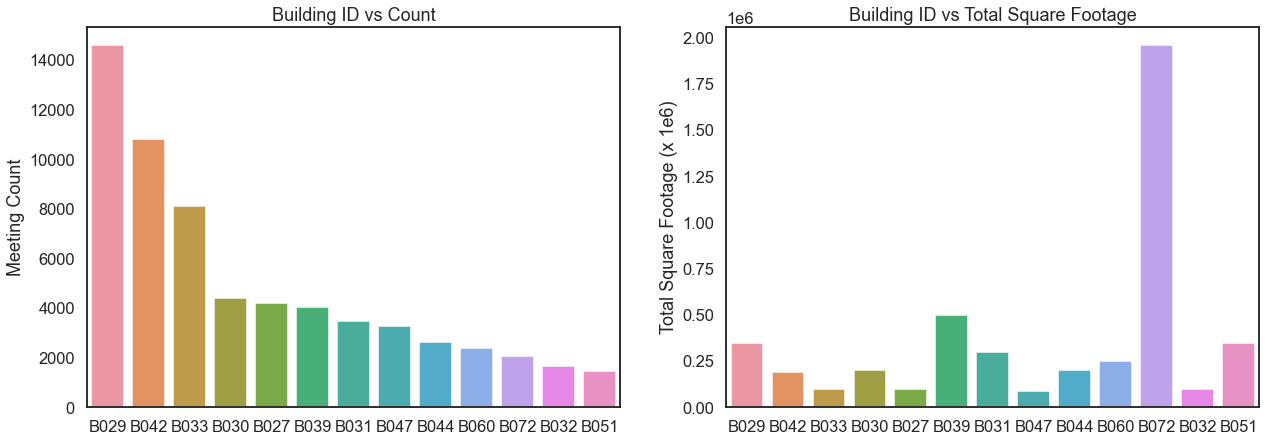

In [25]:
# The first subplot displays the count of building IDs, and the second subplot displays the total square footage of buildings.
fig, ax = plt.subplots(1, 2, figsize=(21, 7))

sns.barplot(x=[i[0] for i in sorted_values], y=[i[1] for i in sorted_values], ax=ax[0])
ax[0].set_title('Building ID vs Count')
ax[0].set_ylabel('Meeting Count')

sns.barplot(x=[i[0] for i in sorted_values], y=[i[2] for i in sorted_values], ax=ax[1])
ax[1].set_title('Building ID vs Total Square Footage')
ax[1].set_ylabel('Total Square Footage (x 1e6)')

- Building popularity and meetings scheduled arent seem to be correlated towards square footage of the building.

In [26]:
Building_df['STATE'].value_counts()[0:10]

California     5
London         2
CA             2
Helsinki       1
Tenessee       1
Uxbridge       1
Bengaluru      1
Maryland       1
MAHARASHTRA    1
Istanbul       1
Name: STATE, dtype: int64

- Finding out if Building's location plays any role in the popularity of the building.

In [27]:
filtered_df = Building_df[
    pd.notna(Building_df['CITY']) |
    pd.notna(Building_df['STATE']) |
    pd.notna(Building_df['COUNTRY']) |
    pd.notna(Building_df['ZIPCODE']) |
    pd.notna(Building_df['ADDRESS'])
]

filtered_df = filtered_df.loc[filtered_df['ADDRESS'] != 'Test']

filtered_df.shape, Building_df.shape

((48, 11), (73, 11))

In [28]:
# filtered_df = filtered_df[pd.notna(filtered_df['ADDRESS'])]

# geolocator = Nominatim(user_agent="address_mapper")

# # Create a map centered around a location (e.g., a city)
# map_center = geolocator.geocode("Frisco, Texas, USA")
# address_map = folium.Map(location=[map_center.latitude, map_center.longitude], zoom_start=10)

# # Function to add markers to the map
# def add_marker(address):
#     location = geolocator.geocode(address)
#     if location:
#         folium.Marker(
#             location=[location.latitude, location.longitude],
#             popup=address
#         ).add_to(address_map)

# # Apply the add_marker function to each address in the DataFrame
# filtered_df['ADDRESS'].apply(add_marker)

# # Display the map
# address_map.save('outputs/map.html')  # Save the map to an HTML file

Map of the buildings:


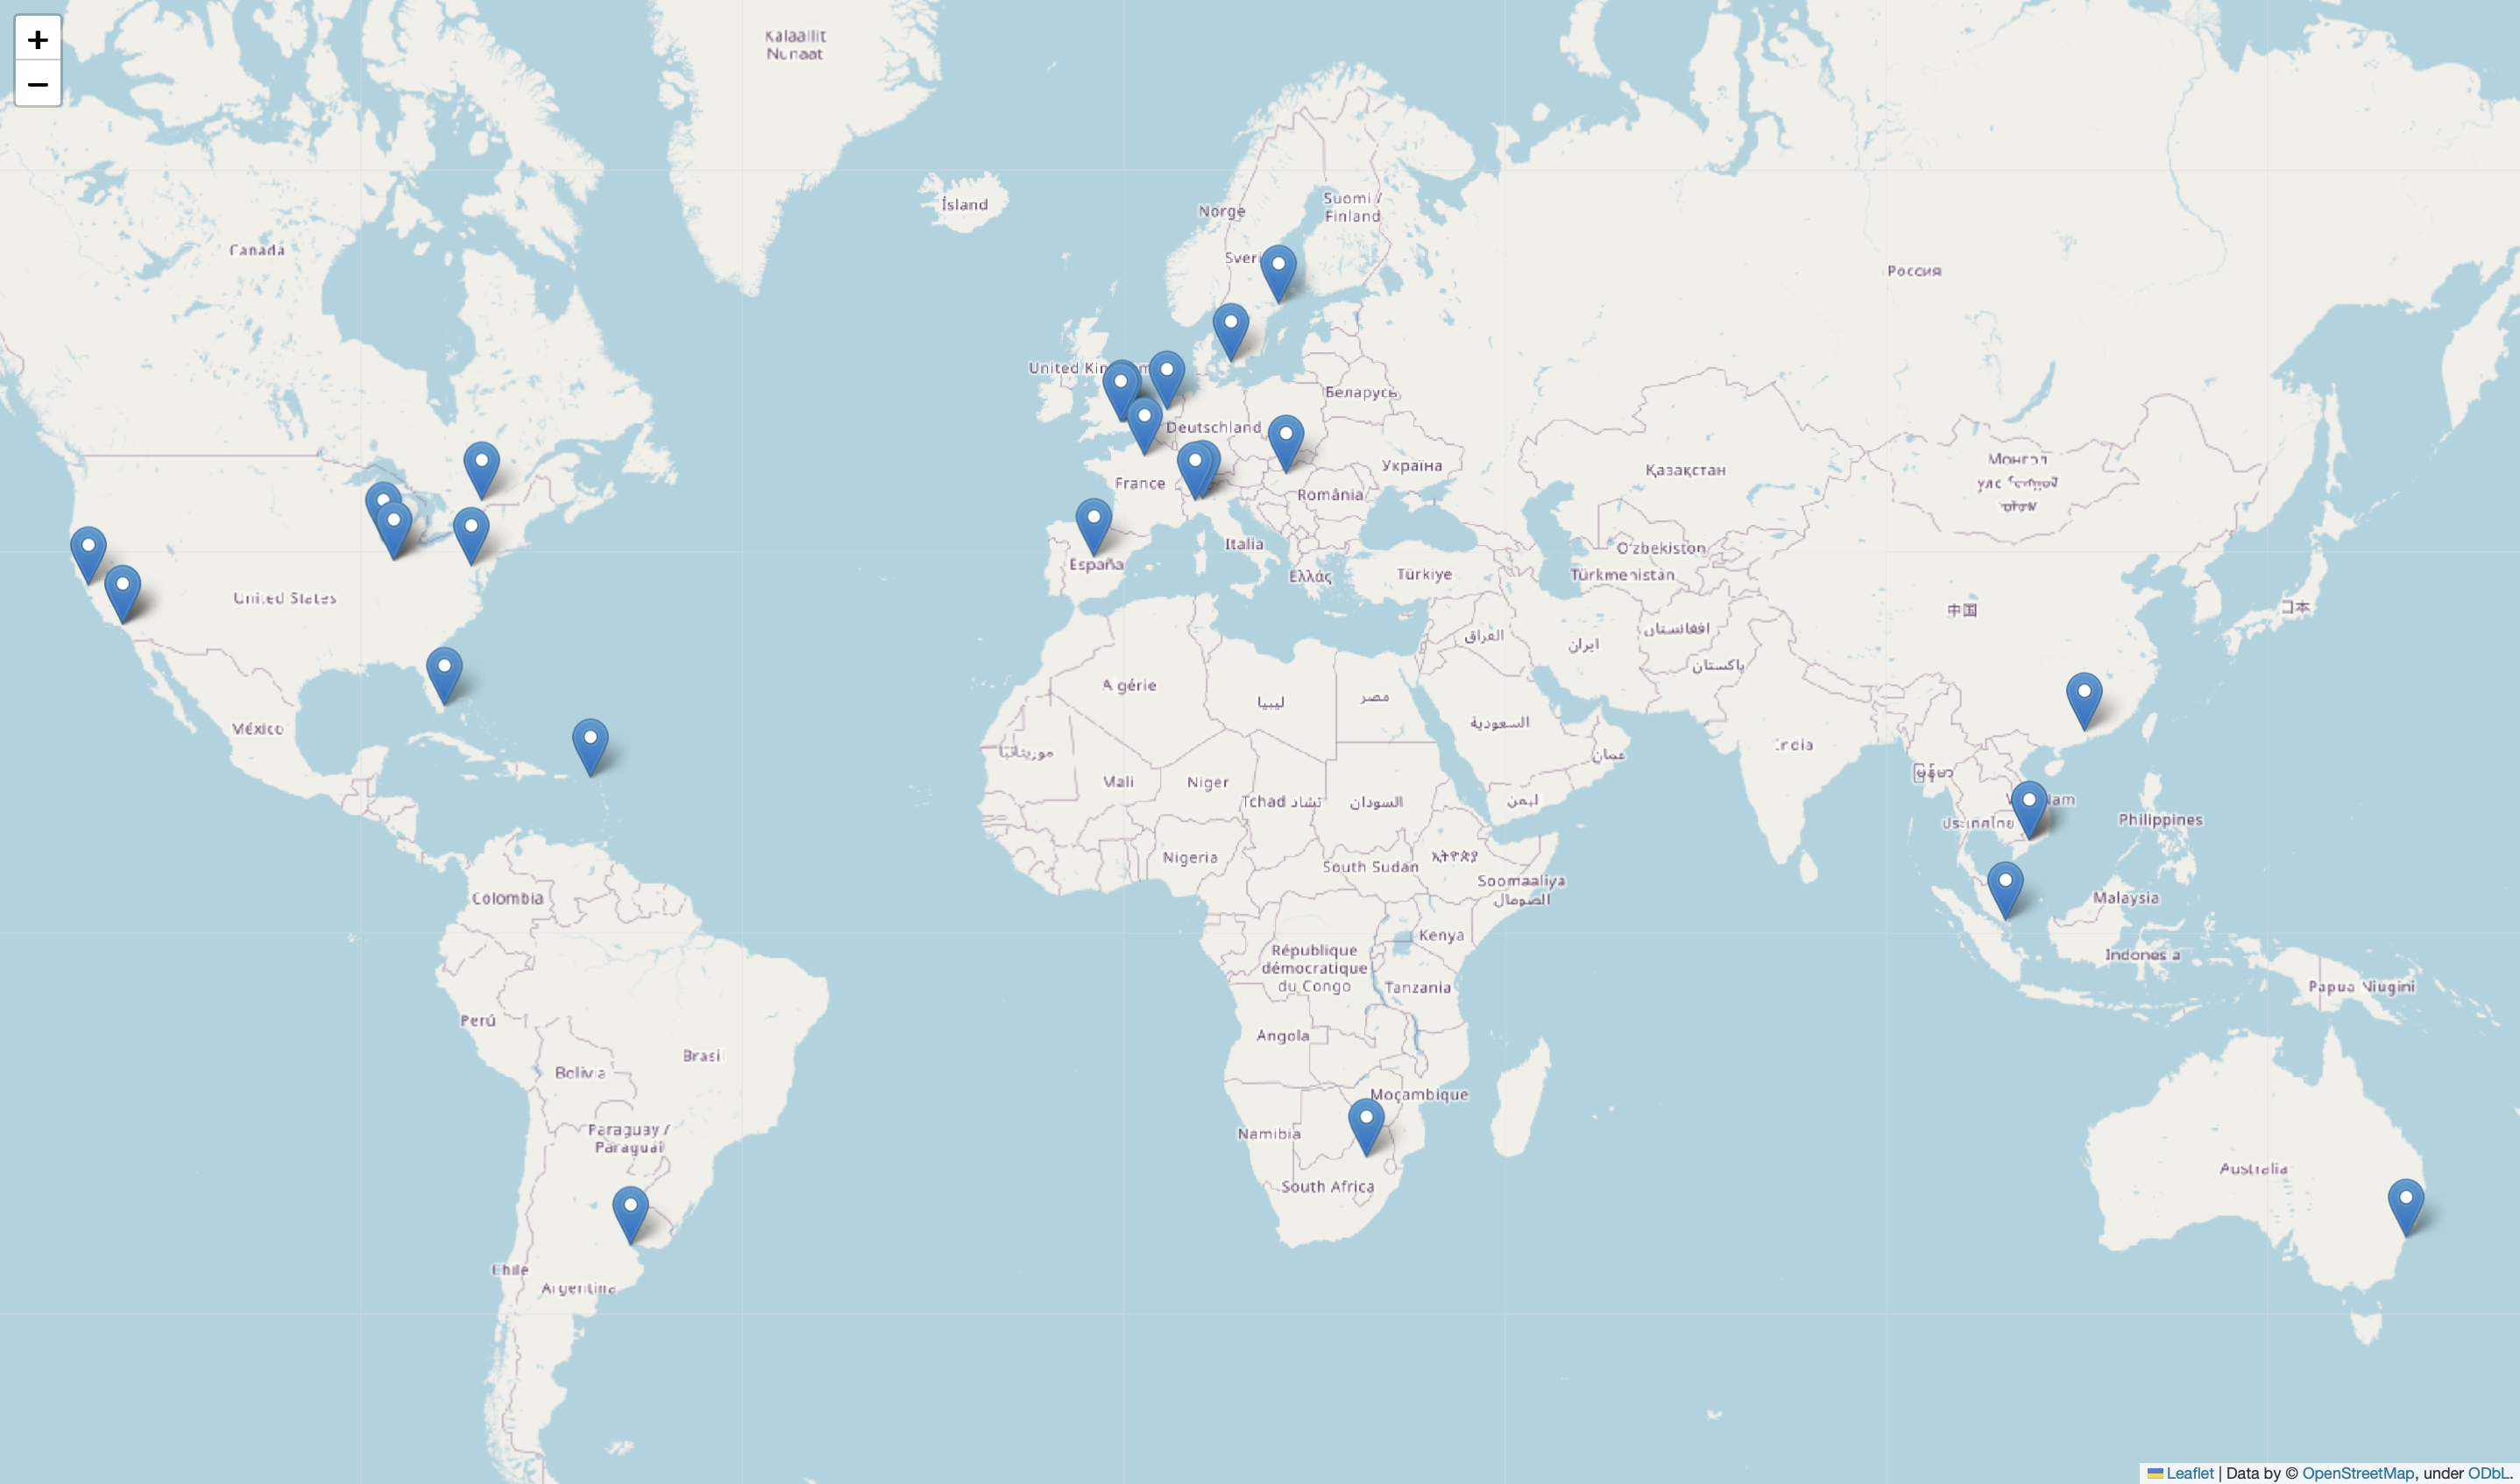

In [29]:
# Specify the path to your image file
image_path = '../outputs/images/map.png'

# Display the image
print('Map of the buildings:')
Image(filename=image_path)

- Finding out if Floor has any correlation with the number of meetings scheduled

In [30]:
data = RoomBookingLog_df.copy()

data = data[['ID', 'BUILDING_ID', 'MEETING_ID', 'MEETING_NAME', 'BUILDING_NAME', 'ACCEPTED_COUNT', 'ROOM_ID', 'INVITED_COUNT', 'FLOOR_ID', 'ROOM_NAME', 'IS_CANCELLED']]
data.head()

,ID,BUILDING_ID,MEETING_ID,MEETING_NAME,BUILDING_NAME,ACCEPTED_COUNT,ROOM_ID,INVITED_COUNT,FLOOR_ID,ROOM_NAME,IS_CANCELLED
0,RB958,B033,M019,Singapore - Solaris,Solaris,1,R1869,1,F108,MR-1314 - Docs Lab Room,False
1,RB847,B060,M044,Tokyo - Hibiya,Hibiya Central Building,1,R835,1,F087,16FN-F,False
2,RB848,B033,M019,Singapore - Solaris,Solaris,1,R1869,1,F108,MR-1314 - Docs Lab Room,False
3,RB689,B042,M032,New York - Hudson Yards,Hudson Yards,1,R1215,1,F210,49D15 - Penn Station,False
4,RB39717,B029,M016,Burbank - Second Century,Tower 1,4,R1985,11,F183,1-3B07,False


In [31]:
Floor_df.columns

Index(['ID', 'MEETING_ID', 'NAME', 'LAST_MODIFIED', 'SQUARE_FOOT',
       'DATE_CREATED', 'BUILDING_ID', 'ACTIVE'],
      dtype='object')

In [32]:
# The columns used for merging are 'FLOOR_ID', 'BUILDING_ID', and 'MEETING_ID'
data = pd.merge(data, Floor_df, how='left', left_on=['FLOOR_ID', 'BUILDING_ID', 'MEETING_ID'], right_on=['ID', 'BUILDING_ID', 'MEETING_ID'])
data.columns

Index(['ID_x', 'BUILDING_ID', 'MEETING_ID', 'MEETING_NAME', 'BUILDING_NAME',
       'ACCEPTED_COUNT', 'ROOM_ID', 'INVITED_COUNT', 'FLOOR_ID', 'ROOM_NAME',
       'IS_CANCELLED', 'ID_y', 'NAME', 'LAST_MODIFIED', 'SQUARE_FOOT',
       'DATE_CREATED', 'ACTIVE'],
      dtype='object')

In [33]:
data['ACTIVE'].value_counts()/data.shape[0]

True     0.993816
False    0.006184
Name: ACTIVE, dtype: float64

In [34]:
data = data.loc[data['ACTIVE'] == True] #dropping the flase values - 0.6%  
data.drop(columns=['ID_y', 'LAST_MODIFIED', 'DATE_CREATED', 'BUILDING_NAME', 'MEETING_NAME', 'ACTIVE', 'IS_CANCELLED', 'BUILDING_ID', 'MEETING_ID', 'ACCEPTED_COUNT', 'ROOM_ID', 'INVITED_COUNT', 'FLOOR_ID', 'ROOM_NAME'], inplace=True)
data.head()

,ID_x,NAME,SQUARE_FOOT
0,RB958,Floor 13,50000
1,RB847,16,50000
2,RB848,Floor 13,50000
3,RB689,49,10000
4,RB39717,Floor 3,50000


In [35]:
data.loc[data['NAME'] == 'Ground', 'NAME'] = 0

# Apply a lambda function to convert the 'NAME' column to integers, replacing empty strings with NaN
data['NAME'] = data['NAME'].apply(lambda x: np.nan if x == '' else int(re.sub(r"[^0-9]", "", str(x))))

data.rename(columns={'ID_x': 'Booking_ID', 'NAME': 'Floor_Number', 'SQUARE_FOOT': 'FLOOR_SQUARE_FOOT'}, inplace=True)

data.head(17).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Booking_ID,RB958,RB847,RB848,RB689,RB39717,RB690,RB39718,RB691,RB39719,RB39720,RB39721,RB39722,RB692,RB714,RB39723,RB39724,RB693
Floor_Number,13,16,13,49,3,3,40,2,2,40,1,14,2,1,2,2,5
FLOOR_SQUARE_FOOT,50000,50000,50000,10000,50000,50000,10000,50000,50000,10000,10000,50000,50000,50000,50000,50000,280000


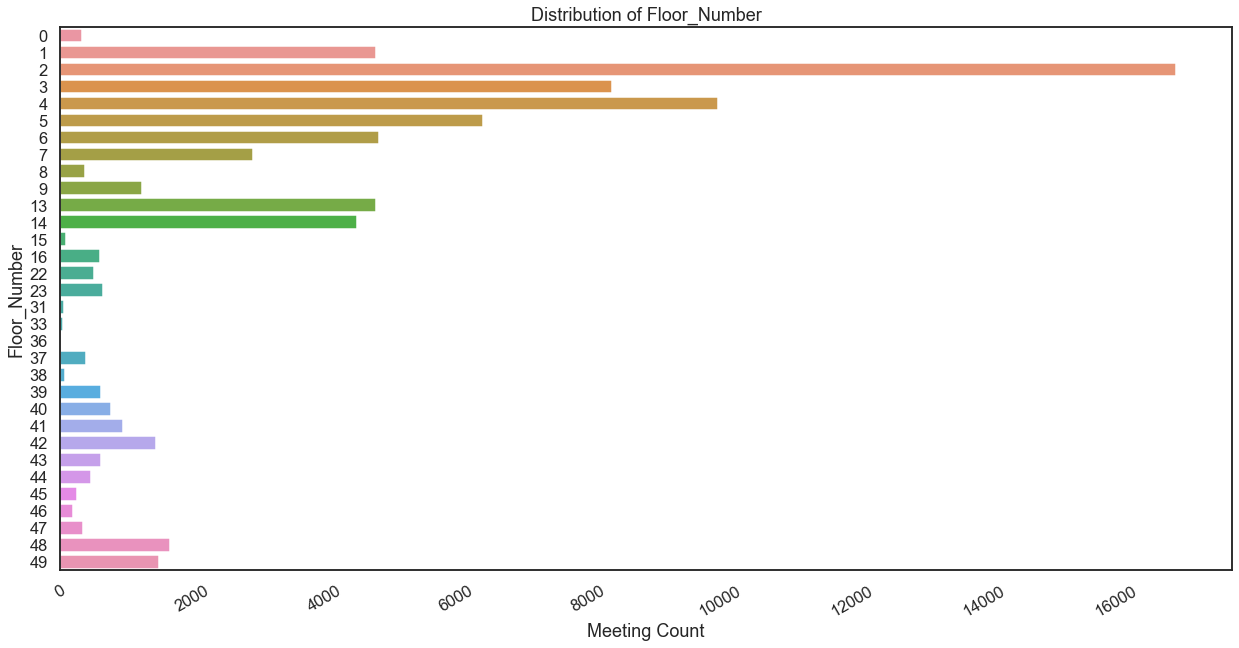

In [36]:
plt.figure(figsize=(21, 10))
sns.barplot(data=data, y=data['Floor_Number'].value_counts().index, x=data['Floor_Number'].value_counts().values, orient='horizontal')
plt.xticks(rotation=30)
plt.ylabel('Floor_Number')
plt.xlabel('Meeting Count')
plt.title('Distribution of Floor_Number')
plt.show()

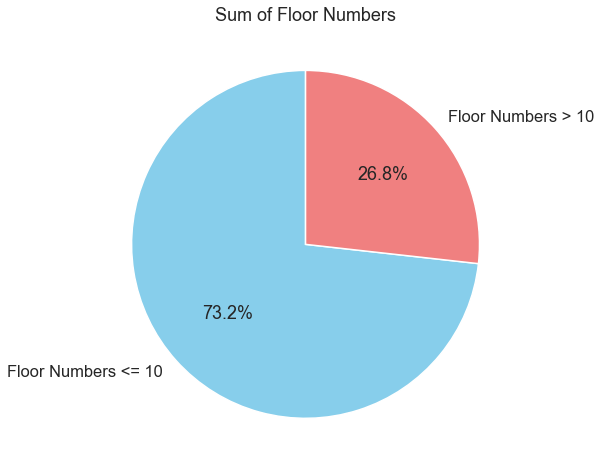

In [37]:
# Count the occurrences of each floor number
floor_counts = data['Floor_Number'].value_counts()

# Separate floor numbers into two categories: <= 10 and > 10
floor_numbers_less_than_or_equal_to_10 = floor_counts[floor_counts.index <= 10].sum()
floor_numbers_greater_than_10 = floor_counts[floor_counts.index > 10].sum()

# Create a dictionary for the pie chart
floor_sums = {
    'Floor Numbers <= 10': floor_numbers_less_than_or_equal_to_10,
    'Floor Numbers > 10': floor_numbers_greater_than_10
}

# Plot a pie chart
plt.figure(figsize=(8, 8))
colors = ['skyblue', 'lightcoral']
plt.pie(floor_sums.values(), labels=floor_sums.keys(), autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Sum of Floor Numbers')
plt.show()

#### Observations:
- Clearly there is a correlation between the floor and the number of meetings scheduled.
- 73.2% of the meetings are scheduled below 10th floor.
- More than 50% of the meetings are scheduled below 5th floor.

#### Closer look into capacity of the meeting rooms, and the number of people attending the meetings.

In [38]:
data = RoomBookingLog_df.copy()
data = data[['ID', 'ACCEPTED_COUNT', 'ROOM_ID', 'INVITED_COUNT']]
data.head()

,ID,ACCEPTED_COUNT,ROOM_ID,INVITED_COUNT
0,RB958,1,R1869,1
1,RB847,1,R835,1
2,RB848,1,R1869,1
3,RB689,1,R1215,1
4,RB39717,4,R1985,11


In [39]:
data = pd.merge(data, Room_df, how='left', left_on='ROOM_ID', right_on='ID')
data = data[['ID_x', 'ACCEPTED_COUNT', 'ROOM_ID', 'INVITED_COUNT', 'CAPACITY']]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77139 entries, 0 to 77138
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID_x            77139 non-null  object 
 1   ACCEPTED_COUNT  77139 non-null  int64  
 2   ROOM_ID         77113 non-null  object 
 3   INVITED_COUNT   77139 non-null  int64  
 4   CAPACITY        77113 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 3.5+ MB


In [40]:
data.dropna(inplace=True)
data = data.loc[(data['ACCEPTED_COUNT'] >0) & (data['INVITED_COUNT'] >0)] #dropping the 0 values

top_5 = data['INVITED_COUNT'].value_counts().sort_index()[0:5].sum()/data['INVITED_COUNT'].value_counts().sum()
print('Top 5 values account for', round(top_5 * 100, 2), '% of the total values')

Top 5 values account for 74.11 % of the total values


- Meaning most of the meetings are scheduled for small groups.

In [41]:
data['Accepted_percent'] = data['ACCEPTED_COUNT']*100/data['INVITED_COUNT']
data['Invited_percent'] = data['INVITED_COUNT']*100/data['CAPACITY']

data_aggregated = data.groupby('CAPACITY').agg({'Accepted_percent': 'mean', 'Invited_percent': 'mean'}).reset_index()
data_aggregated.head().T

,0,1,2,3,4
CAPACITY,1.000000,2.000000,3.000000,4.000000,5.000000
Accepted_percent,94.546131,80.079340,81.836108,84.605806,89.218964
Invited_percent,122.879464,179.014989,113.585027,72.262774,67.144000


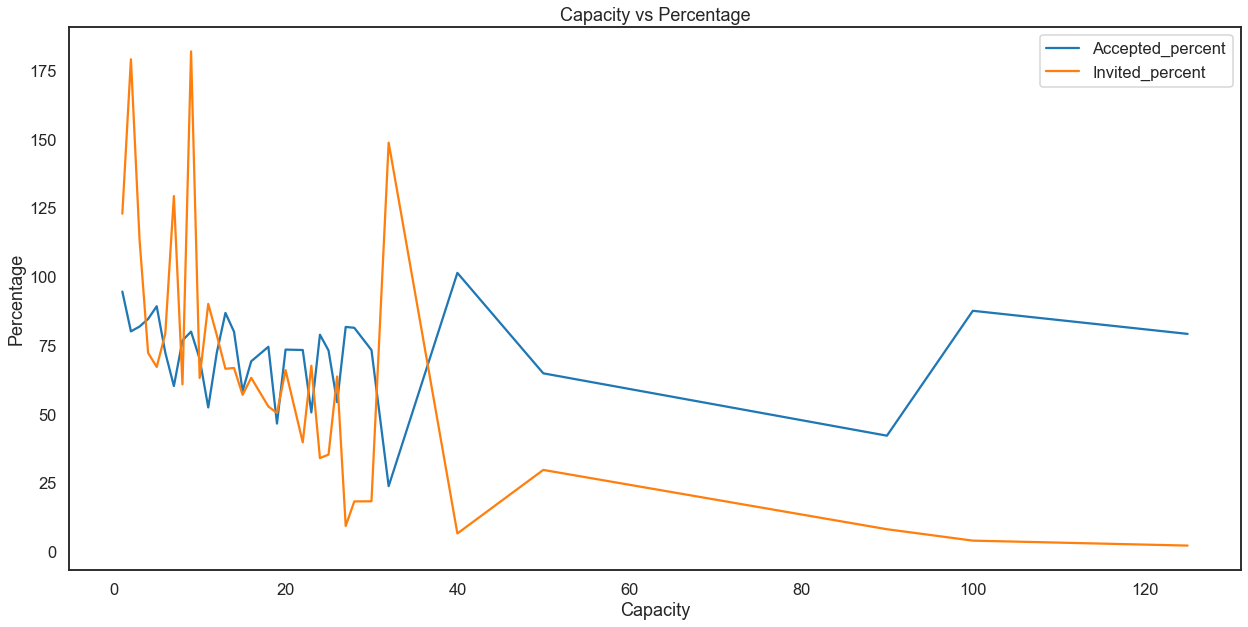

In [42]:
plt.figure(figsize=(21, 10))
sns.lineplot(data=data_aggregated, x='CAPACITY', y='Accepted_percent', label='Accepted_percent')
sns.lineplot(data=data_aggregated, x='CAPACITY', y='Invited_percent', label='Invited_percent')
plt.xlabel('Capacity')
plt.ylabel('Percentage')
plt.title('Capacity vs Percentage')
plt.legend()
plt.show()

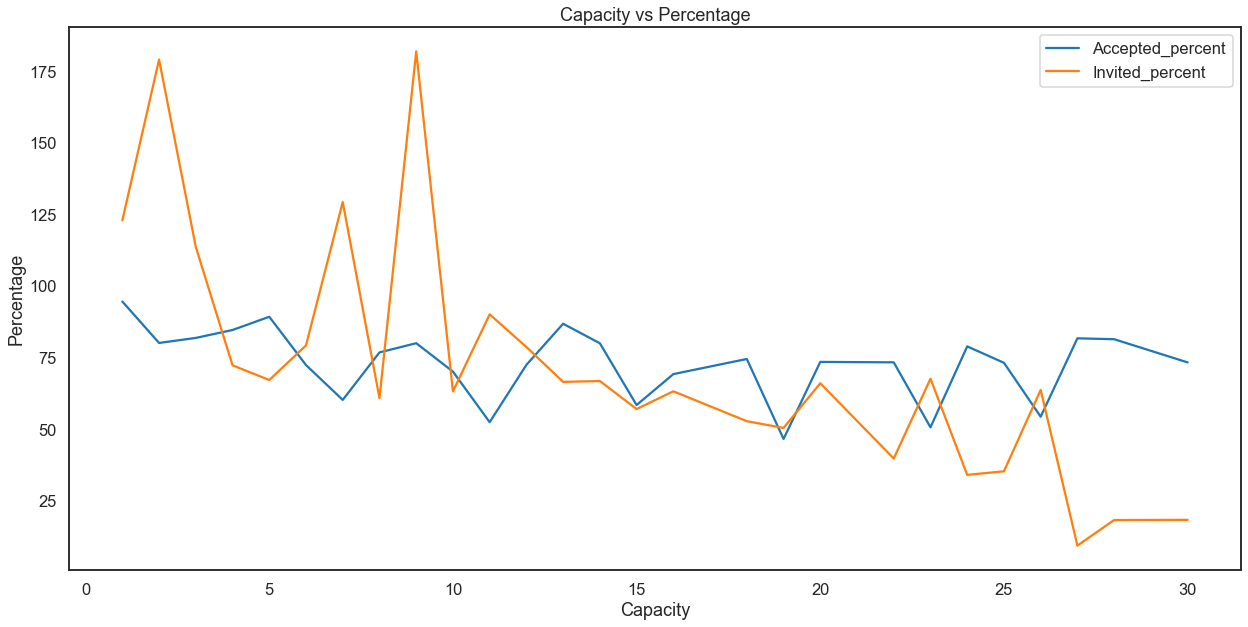

In [43]:
plt.figure(figsize=(21, 10))
sns.lineplot(data=data_aggregated.loc[data_aggregated['CAPACITY'] <= 30], x='CAPACITY', y='Accepted_percent', label='Accepted_percent')
sns.lineplot(data=data_aggregated.loc[data_aggregated['CAPACITY'] <= 30], x='CAPACITY', y='Invited_percent', label='Invited_percent')
plt.xlabel('Capacity')
plt.ylabel('Percentage')
plt.title('Capacity vs Percentage')
plt.legend()
plt.show()

- Most of the meetings are scheduled in the meeting rooms with capacity of less than 30 people have an average of 75% occupancy.
- While invited attendees doesnt seem to have any strong correlation with the attended attendees and the capacity of the meeting room.